## 0.6 Item-based recommender using Nearest Neighbor method

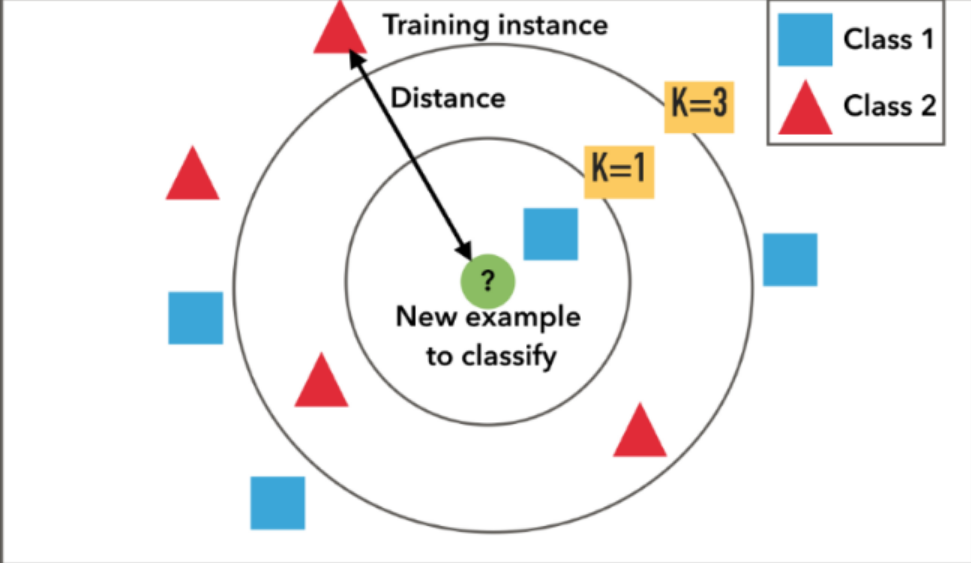

## Import libraries

In [232]:
import sys
import os
import pandas as pd
import numpy as np
from math import sqrt
from sklearn.model_selection import train_test_split # data splitting 
import warnings
warnings.filterwarnings("ignore")
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error
from sklearn.metrics import pairwise_distances

## Data

In [259]:
movies = pd.read_csv('../../data/movies.csv', sep= ",")
ratings = pd.read_csv('../../data/ratings.csv', sep= ",")

In [260]:
# Merged data by movieId
new_df = pd.merge(ratings, movies, on='movieId', how='inner')
new_df = new_df.head(1000000)
data_movies.head()


movieId             title                                       genres  \
0        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
1        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
2        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
3        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
4        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   

   userId  rating   timestamp  
0       2     3.5  1141415820  
1       3     4.0  1439472215  
2       4     3.0  1573944252  
3       5     4.0   858625949  
4       8     4.0   890492517

In [261]:
#know what movies the users are already rated

missing_pivot = new_df.pivot_table(values = 'rating', index = 'userId', columns = 'title')
missing_pivot.head()

title   2046 (2004)  5x2 (2004)  \
userId                            
1               4.5         3.5   
2               NaN         NaN   
3               NaN         NaN   
4               NaN         NaN   
5               NaN         NaN   

title   Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)  \
userId                                                         
1                                                     4.5      
2                                                     NaN      
3                                                     NaN      
4                                                     NaN      
5                                                     NaN      

title   Apollo 13 (1995)  Back to the Future Part II (1989)  \
userId                                                        
1                    NaN                                2.5   
2                    4.0                                NaN   
3                    NaN                                NaN   
4                    NaN                                NaN   
5                    5.0                                NaN   

title   Back to the Future Part III (1990)  \
userId                                       
1                                      2.5   
2                                      NaN   
3                                      NaN   
4                                      NaN   
5                                      NaN   

title   Bad Education (La mala educación) (2004)  \
userId                                             
1                                            4.0   
2                                            NaN   
3                                            NaN   
4                                            NaN   
5                                            NaN   

title   Barbarian Invasions, The (Les invasions barbares) (2003)  \
userId                                                             
1                                                     3.5          
2                                                     NaN          
3                                                     NaN          
4                                                     NaN          
5                                                     NaN          

title   Black Cat, White Cat (Crna macka, beli macor) (1998)  \
userId                                                         
1                                                     4.5      
2                                                     NaN      
3                                                     NaN      
4                                                     NaN      
5                                                     NaN      

title   Braveheart (1995)  ...  \
userId                     ...   
1                     NaN  ...   
2                     5.0  ...   
3                     NaN  ...   
4                     NaN  ...   
5                     NaN  ...   

title   Three Colors: Blue (Trois couleurs: Bleu) (1993)  \
userId                                                     
1                                                    5.0   
2                                                    NaN   
3                                                    NaN   
4                                                    NaN   
5                                                    NaN   

title   Three Colors: Red (Trois couleurs: Rouge) (1994)  \
userId                                                     
1                                                    3.5   
2                                                    NaN   
3                                                    NaN   
4                                                    NaN   
5                                                    NaN   

title   Through a Glass Darkly (Såsom i en spegel) (1961)  Tommy Boy (1995)  \
userId                                                                        
1         

In [263]:
# Identify the movies each user have rated
rate = {}
rows_indexes = {}
for i, row in missing_pivot.iterrows():
    rows = [x for x in range(0,len(missing_pivot.columns))]
    combine = list(zip(row.index, row.values, rows))
    rated = [(x,z) for x,y,z in combine if str(y) != 'nan']
    index = [i[1] for i in rated]
    row_names = [i[0] for i in rated]
    rows_indexes[i] = index
    rate[i] = row_names

In [264]:
rated_movies

{2: ['Apollo 13 (1995)',
  'Braveheart (1995)',
  'Clear and Present Danger (1994)',
  'French Kiss (1995)',
  'Gattaca (1997)',
  'Legends of the Fall (1994)',
  'Little Women (1994)',
  'Lord of the Rings: The Two Towers, The (2002)',
  "Mr. Holland's Opus (1995)",
  'Pirates of the Caribbean: The Curse of the Black Pearl (2003)',
  'Rob Roy (1995)',
  'Shawshank Redemption, The (1994)',
  'Shrek 2 (2004)',
  'Star Wars: Episode IV - A New Hope (1977)',
  'Tommy Boy (1995)',
  'Toy Story (1995)'],
 3: ['City of God (Cidade de Deus) (2002)',
  'Eternal Sunshine of the Spotless Mind (2004)',
  'Finding Nemo (2003)',
  'Gattaca (1997)',
  'Lord of the Rings: The Two Towers, The (2002)',
  'Lost in Translation (2003)',
  'Moulin Rouge (2001)',
  'Pirates of the Caribbean: The Curse of the Black Pearl (2003)',
  'Pulp Fiction (1994)',
  'Ran (1985)',
  'Shawshank Redemption, The (1994)',
  'Shrek 2 (2004)',
  'Star Wars: Episode IV - A New Hope (1977)',
  'Toy Story (1995)'],
 4: ['Findin

### User-item Matrix

Now we try to find the movies the users have not rated yet, we don't want to recommed movies that the users have already watched.

In [266]:
pivot_table = new_df.pivot_table(values = 'rating', index = 'userId', columns = 'title').fillna(0)
pivot_table.head()

title   2046 (2004)  5x2 (2004)  \
userId                            
1               4.5         3.5   
2               0.0         0.0   
3               0.0         0.0   
4               0.0         0.0   
5               0.0         0.0   

title   Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)  \
userId                                                         
1                                                     4.5      
2                                                     0.0      
3                                                     0.0      
4                                                     0.0      
5                                                     0.0      

title   Apollo 13 (1995)  Back to the Future Part II (1989)  \
userId                                                        
1                    0.0                                2.5   
2                    4.0                                0.0   
3                    0.0                                0.0   
4                    0.0                                0.0   
5                    5.0                                0.0   

title   Back to the Future Part III (1990)  \
userId                                       
1                                      2.5   
2                                      0.0   
3                                      0.0   
4                                      0.0   
5                                      0.0   

title   Bad Education (La mala educación) (2004)  \
userId                                             
1                                            4.0   
2                                            0.0   
3                                            0.0   
4                                            0.0   
5                                            0.0   

title   Barbarian Invasions, The (Les invasions barbares) (2003)  \
userId                                                             
1                                                     3.5          
2                                                     0.0          
3                                                     0.0          
4                                                     0.0          
5                                                     0.0          

title   Black Cat, White Cat (Crna macka, beli macor) (1998)  \
userId                                                         
1                                                     4.5      
2                                                     0.0      
3                                                     0.0      
4                                                     0.0      
5                                                     0.0      

title   Braveheart (1995)  ...  \
userId                     ...   
1                     0.0  ...   
2                     5.0  ...   
3                     0.0  ...   
4                     0.0  ...   
5                     0.0  ...   

title   Three Colors: Blue (Trois couleurs: Bleu) (1993)  \
userId                                                     
1                                                    5.0   
2                                                    0.0   
3                                                    0.0   
4                                                    0.0   
5                                                    0.0   

title   Three Colors: Red (Trois couleurs: Rouge) (1994)  \
userId                                                     
1                                                    3.5   
2                                                    0.0   
3                                                    0.0   
4                                                    0.0   
5                                                    0.0   

title   Through a Glass Darkly (Såsom i en spegel) (1961)  Tommy Boy (1995)  \
userId                                                                        
1         

In [268]:
pivot_table = pivot_table.apply(np.sign)

In [273]:
# Identify the movies that users have not rated yet

notrated = {}
notrated_indexes= {}
for i, row in pivot_table.iterrows():
    rows = [x for x in range(0,len(missing_pivot.columns))]
    combine = list(zip(row.index, row.values, row))
    idx_row = [(idx,col) for idx, val, col in combine if not val > 0]
    indices = [i[1] for i in idx_row]
    row_names = [i[0] for i in idx_row]
    notrated_indexes[i] = indices
    notrated[i] = row_names

In [274]:
notrated

{1: ['Apollo 13 (1995)',
  'Braveheart (1995)',
  'Clear and Present Danger (1994)',
  'French Kiss (1995)',
  'Legends of the Fall (1994)',
  'Little Women (1994)',
  "Mr. Holland's Opus (1995)",
  'Rob Roy (1995)',
  'Shawshank Redemption, The (1994)',
  'Star Wars: Episode IV - A New Hope (1977)',
  'Tommy Boy (1995)',
  'Toy Story (1995)'],
 2: ['2046 (2004)',
  '5x2 (2004)',
  "Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)",
  'Back to the Future Part II (1989)',
  'Back to the Future Part III (1990)',
  'Bad Education (La mala educación) (2004)',
  'Barbarian Invasions, The (Les invasions barbares) (2003)',
  'Black Cat, White Cat (Crna macka, beli macor) (1998)',
  'Bridge on the River Kwai, The (1957)',
  'Chocolat (1988)',
  'City of God (Cidade de Deus) (2002)',
  'Cries and Whispers (Viskningar och rop) (1972)',
  'Delicatessen (1991)',
  'Dirty Dancing (1987)',
  'Dolce Vita, La (1960)',
  'Dolls (2002)',
  'Eternal Sunshine of the Spotless Mind (2004)',
  'Fanny and

### Unsupervised Nearest Neighbor Recommender

In [275]:
n = 5
cosine_knn = NearestNeighbors(n_neighbors = n,algorithm = 'brute', metric = 'cosine')
item_cosine_knn_fit = cosine_knn.fit(pivot_table.T.values) 
item_distances, item_indices = item_cosine_knn_fit.kneighbors(pivot_table.T.values) 

#### Item-based Recommender

In [278]:
items_dic = {}
for i in range(len(pivot_table.T.index)):
    item_idx = item_indices[i]
    col_names = pivot_table.T.index[item_idx].tolist()
    items_dic[pivot_table.T.index[i]] = col_names

In [279]:
items_dic

{'2046 (2004)': ['2046 (2004)',
  'In the Mood For Love (Fa yeung nin wa) (2000)',
  'Spring, Summer, Fall, Winter... and Spring (Bom yeoreum gaeul gyeoul geurigo bom) (2003)',
  'Bad Education (La mala educación) (2004)',
  'Dolls (2002)'],
 '5x2 (2004)': ['5x2 (2004)',
  'Look at Me (Comme une image) (2004)',
  'Bad Education (La mala educación) (2004)',
  'Piano Teacher, The (La pianiste) (2001)',
  '2046 (2004)'],
 "Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)": ["Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)",
  'Eternal Sunshine of the Spotless Mind (2004)',
  'Lord of the Rings: The Two Towers, The (2002)',
  'Lost in Translation (2003)',
  'Finding Nemo (2003)'],
 'Apollo 13 (1995)': ['Apollo 13 (1995)',
  'Braveheart (1995)',
  'Pulp Fiction (1994)',
  'Shawshank Redemption, The (1994)',
  'Toy Story (1995)'],
 'Back to the Future Part II (1989)': ['Back to the Future Part II (1989)',
  'Back to the Future Part III (1990)',
  'Star Wars: Episode IV - A New Hope 

In [280]:
topRecs = {}
for k,v in rows_indexes.items():
    item_idx = [j for i in item_indices[v] for j in i]
    item_dist = [j for i in item_distances[v] for j in i]
    combine = list(zip(item_dist, item_idx))
    diction = {i:d for d, i in combine if i not in v}
    zipped = list(zip(diction.keys(),diction.values()))
    sort = sorted(zipped, key = lambda x: x[1])
    recommendations = [(pivot_table.columns[i],d) for i, d in sort]
    topRecs[k]= recommendations
#k = users

In [281]:
def getrecommendations(user, number_of_recs = 30):
    if user > len(pivot_table.index):
        print('Out of range, there are only {} users, try again!'.format(len(df_pivot_2.index)))
    else:
        
        print("These are all the movies you have viewed in the past: \n\n{}".format('\n'.join(rate[user])))
        print()
        print("We recommed to view these movies too:\n")
    for k,v in topRecs.items():
        if user == k:
            for i in v[:number_of_recs]:
                print('{} with similarity: {:.4f}'.format(i[0], 1 - i[1]))

In [282]:
getrecommendations(601)

These are all the movies you have viewed in the past: 

Apollo 13 (1995)
Braveheart (1995)
Bridge on the River Kwai, The (1957)
Clear and Present Danger (1994)
Mr. Holland's Opus (1995)
Singin' in the Rain (1952)
Star Wars: Episode IV - A New Hope (1977)
Toy Story (1995)

We recommed to view these movies too:

Lord of the Rings: The Two Towers, The (2002) with similarity: 0.5685
Pulp Fiction (1994) with similarity: 0.5256
Shawshank Redemption, The (1994) with similarity: 0.5071
Dirty Dancing (1987) with similarity: 0.3068
Good Morning, Vietnam (1987) with similarity: 0.3024
Legends of the Fall (1994) with similarity: 0.2983
Ran (1985) with similarity: 0.2928


#### Rating predictions for the movies users had not seen before

In [283]:
item_distances = 1 - item_distances


In [284]:
predictions = item_distances.T.dot(pivot_table.T.values)/np.array([np.abs(item_distances.T).sum(axis = 1)]).T

In [285]:
ground_truth = pivot_table.T.values[item_distances.argsort()[0]]

#### Evaluating the recommendation model

In [288]:
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten()
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt (mean_squared_error(prediction, ground_truth))

In [289]:
error_rate = rmse(predictions, ground_truth)
print("Acuraccy: {:.3f}".format(100 - error_rate))
print("RMSE: {:.5f}".format(error_rate))

Acuraccy: 99.175
RMSE: 0.82473
